<a href="https://colab.research.google.com/github/Pradeepjha88/Logistic-regression/blob/main/S12b_multiple_hidden_layer_L2_binary_output_wip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 12b

# Simulating over fitting

## Multiple Hidden Layers Binary output with L2 regularization

$\large{\text{Large Regularization }\lambda = 0.4}$

</p><img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

# Story So Far 
    
<div style="font-family: Arial; font-size:1.2em;color:black;">
    Lets track the results across various implementations... 
    </div>
    
    
|#|Sheet #|Dataset|Implementation|Training Accuracy|Testing Accuracy|Remarks|
|:-:|:-:|:-:|:--|---|---|:--|
|1|S04a|make_moons|Simple Perceptron|0.84111|0.89000||
|2|S04b|make_moons|Perceptron including Softmax and Gradient Descent|0.86555|0.90000|Training Accuracy catching up|
|3|S06a|make_moons|One hidden layer with ${Tanh}$ activation|0.96875|0.96094| Better, non-linearity helps|
|4|S06b|make_moons|One hidden layer with ${ReLU}$ activation|0.96387|0.96875| Still better, Taking little longer to converge|
|5|S06c|make_moons|One hidden layer with ${Swish}$ activation|0.96680|0.96094| Similar results, Taking even longer to converge|
|6|S06d|make_circles|One hidden layer with ${Tanh}$ activation|0.83643|0.82715| Different dataset|
|7|S06e|make_circles|One hidden layer with ${ReLU}$ activation|0.83130|0.82910| Better than $Tanh$|
|8|S06f|make_circles|One hidden layer with ${Swish}$ activation|0.83471|0.83301| Better than other two|
|9|S07a|make_circles|Multiple Hidden Layers|0.96875|0.96094|Similar results.|
|10|S08a|make_circles|Multiple Hidden Layers L1 regularization|0.97070|0.96094|Similar results.|


In [ ]:
# Lets import some libraries
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn import datasets

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [ ]:
# Some basic parameters

inpDir = '../input' # location where input data is stored

outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results


EPOCHS = 50000 # number of cycles to run

ALPHA = 0.1 # learning rate

LAMBDA = 0.4 # regularization lambda

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15, 12),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Generate Data Set
<p style="font-family: Arial; font-size:1.2em;color:black;">
Use Sklearn's dataset generator <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</p>

In [ ]:
X, y = datasets.make_moons(n_samples=1280, shuffle=True, noise=0.2, random_state=RANDOM_STATE)

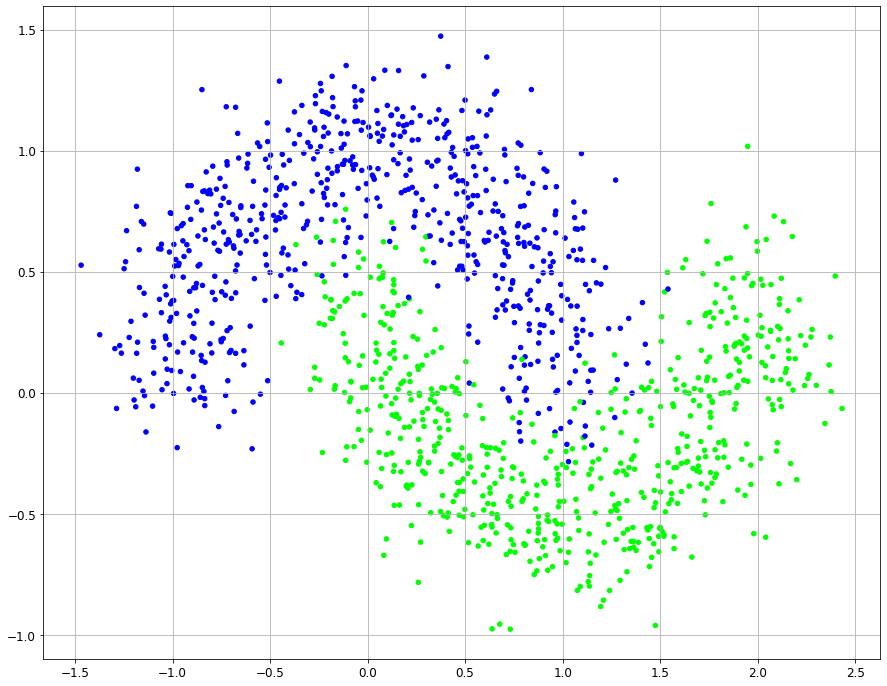

In [ ]:
# Plot the data
plt.scatter(X[:,0], X[:,1], s=20, c=y, cmap=CMAP)

plt.grid()

In [ ]:
def fn_plot_decision_boundary(pred_func, X, y):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X : feature matrix
           y : targets
       Return:
           None           
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=CMAP)
    
    # plot the points as well
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=CMAP, edgecolors='black')

In [ ]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024,) (256, 2) (256,)


## Regularization
<dim style="font-family: Arial; font-size:1.2em;color:black;">
    The standard way to avoid over-fitting is either <b>L1 or L2 regularization</b>. It consists of appropriately modifying our Loss and Cost function:
    <h4>Loss:</h4>
$$
\begin{aligned}
L(\hat{y},y) =  -y.log\hat{y} - (1-y) . log(1-\hat{y})
\end{aligned}
$$
   <h4>Cost:</h4>
$$J(\hat{y}, y) =  -\frac{1}{m}\sum\limits_{i = 1}^{m} [y_i.log\hat{y_i} - (1-y_i) . log(1-\hat{y_i})] \tag{1}$$

<dim style="font-family: Arial; font-size:1.2em;color:black;"> 
    <h3>L2 Regularization</h3>
    <b>L2 Cost:</b>
$$J(\hat{y}, y)_{regularized} = \small \underbrace{-\frac{1}{m}\sum\limits_{i = 1}^{m} [y_i.log\hat{y_i} - (1-y_i) . log(1-\hat{y_i})]}_\text{cross-entropy cost} + \underbrace{\frac{\lambda}{2 * m}\sum\limits_{i = 1}^{L} ||W||_F^2}_\text{L2 regularization cost} \tag{2}$$
    $$J(\hat{y}, y)_{regularized} = \small \underbrace{-\frac{1}{m}\sum\limits_{i = 1}^{m} [y_i.log\hat{y_i} - (1-y_i) . log(1-\hat{y_i})]}_\text{cross-entropy cost} + \underbrace{\frac{\lambda}{2 * m}\sum\limits_{i = 1}^{L} \sum\limits_{j = 1}^{l-1} \sum\limits_{k = 1}^{l} w_{j,k}^{[i]} * w_{j,k}^{[i]}}_\text{L2 regularization cost} \tag{3}$$
</dim>

In [ ]:
# Helper function to evaluate the total loss on the dataset

def calculate_loss(model, X, y, reg_lambda):
    
    # Extract weights and losses from the model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
    
    m = X.shape[0] # replacement for num_examples
    
    # Layer 1
    Z1 = X.dot(W1) + b1 
    A1 = np.tanh(Z1)    # tanh activation
    assert (Z1.shape == A1.shape),"Shape of Z1 and A1 do not match"

    # Layer 2
    Z2 = A1.dot(W2) + b2 
    A2 = np.tanh(Z2)    # tanh activation
    assert (Z2.shape == A2.shape),"Shape of Z2 and A2 do not match"

    # Layer 3
    Z3 = A2.dot(W3) + b3 
    A3 = np.tanh(Z3)    # tanh activation
    assert (Z3.shape == A3.shape),"Shape of Z3 and A3 do not match"

    # Layer 4
    Z4 = A3.dot(W4) + b4 
    A4 = np.tanh(Z4)    # tanh activation
    assert (Z4.shape == A4.shape),"Shape of Z4 and A4 do not match"

    # Layer 5
    Z5 = A4.dot(W5) + b5
    exp_scores = np.exp(Z5) # softmax for final layer as it is binary classification
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
    # Calculating the loss
    # Cross entropy = ground truth x log (predicted)
    # probability of y being correct is 1. hence it will be a vector of [1,1,...,1,1]
    
    correct_logprobs = -np.log(probs[np.arange(m), y]) 
    data_loss = np.sum(correct_logprobs)
    
    #***************************************************************************************
    ######################
    ### Regularization ###
    ######################

    # Add regulatization term to loss
    data_loss += reg_lambda/2 * (np.sum(W1**2) + 
                                 np.sum(W2**2) +
                                 np.sum(W3**2) +
                                 np.sum(W4**2) +
                                 np.sum(W5**2) )
    #**************************************************************************************
        
    return 1./m * data_loss

In [ ]:
#### verification 


W = np.array([[1, 2, 3], [1, 2, 3]])
print (np.sum(W**2))  # 1 + 4 + 9  + 1 + 4 + 9
print (np.linalg.norm(W))

28
5.291502622129181


## Predict Function

In [ ]:
# Helper function to predict an output (0 or 1)

def predict(model, x):
    '''
     Args:
         model
         x: input features
    '''
    # Extract weights and losses from the model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
    
    #***********************************
    # Layer 1
    Z1 = x.dot(W1) + b1 
    A1 = np.tanh(Z1)    # tanh activation
    assert (Z1.shape == A1.shape),"Shape of Z1 and A1 do not match"

    # Layer 2
    Z2 = A1.dot(W2) + b2 
    A2 = np.tanh(Z2)    # tanh activation
    assert (Z2.shape == A2.shape),"Shape of Z2 and A2 do not match"

    # Layer 3
    Z3 = A2.dot(W3) + b3 
    A3 = np.tanh(Z3)    # tanh activation
    assert (Z3.shape == A3.shape),"Shape of Z3 and A3 do not match"

    # Layer 4
    Z4 = A3.dot(W4) + b4 
    A4 = np.tanh(Z4)    # tanh activation
    assert (Z4.shape == A4.shape),"Shape of Z4 and A4 do not match"

    # Layer 5
    Z5 = A4.dot(W5) + b5
    
    # use softmax
    exp_scores = np.exp(Z5) # softmax for final layer as it is binary classification
    
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
      
    return np.argmax(probs, axis=1) # pick with one with highest probabilities

## Back-propagation
<dim style="font-family: Arial; font-size:1.2em;color:black;"> 
    <h3>L2 Regularization</h3>
The differentiation term for L2 will be added for back propogation. Thus:
 
$$
\begin{aligned}
W^{[l]} =  W^{[l]} - \alpha [ a^{[l]} . \partial{ z^{[l]} } + \frac{\lambda}{m} W^{[l]}
\end{aligned}
$$
    </dim>
    
     

In [ ]:
# prepare the Model

def build_model(param, X, y, X_t, y_t,
                epochs=2000,
                alpha = 0.1,
                reg_lambda = 0.1,
                print_loss=False):
    
    '''
        nn_hdim : Number of nodes in the hidden layer
        X : Features to train on
        y : Targets to train on
        epochs : Number of passes through the training data for gradient descent
        alpha : learning rate
        reg_lambda : lambda for regularization 
        print_loss : If True, print the loss every 1000 iterations
    '''
    # set Random Seed
    np.random.seed(RANDOM_STATE)
    
    # Initialize the parameters to random values. We need to learn these.
    W1 = np.random.randn(param['nn_hdim'][0], param['nn_hdim'][1]) / np.sqrt(param['nn_hdim'][0])
    b1 = np.zeros((1, param['nn_hdim'][1]))
    
    W2 = np.random.randn(param['nn_hdim'][1], param['nn_hdim'][2]) / np.sqrt(param['nn_hdim'][1])
    b2 = np.zeros((1, param['nn_hdim'][2]))
    
    W3 = np.random.randn(param['nn_hdim'][2], param['nn_hdim'][3]) / np.sqrt(param['nn_hdim'][2])
    b3 = np.zeros((1, param['nn_hdim'][3]))
    
    W4 = np.random.randn(param['nn_hdim'][3], param['nn_hdim'][4]) / np.sqrt(param['nn_hdim'][3])
    b4 = np.zeros((1, param['nn_hdim'][4]))
   
    W5 = np.random.randn(param['nn_hdim'][4], nn_output_dim) / np.sqrt(param['nn_hdim'][4])
    b5 = np.zeros((1, nn_output_dim))

    # Store model parameters in a dict to retuen in the end
    model = {}
    
    assert (W1.shape == tuple(param['nn_hdim'][0:2])), 'Incorrect shape of W1 :{}'.format(W1.shape)
    
    curr_loss = 0
    ct_loss = 0
    loss = []
    epoch = []
    t_loss = []
    
    # Gradient descent. For each batch...
    for i in range(0, epochs):

        ###  Forward propagation
        # Layer 1
        Z1 = X.dot(W1) + b1 
        A1 = np.tanh(Z1)    # tanh activation
        assert (Z1.shape == A1.shape),"Shape of Z1 and A1 do not match"
        
        # Layer 2
        Z2 = A1.dot(W2) + b2 
        A2 = np.tanh(Z2)    # tanh activation
        assert (Z2.shape == A2.shape),"Shape of Z2 and A2 do not match"
        
        # Layer 3
        Z3 = A2.dot(W3) + b3 
        A3 = np.tanh(Z3)    # tanh activation
        assert (Z3.shape == A3.shape),"Shape of Z3 and A3 do not match"

        # Layer 4
        Z4 = A3.dot(W4) + b4 
        A4 = np.tanh(Z4)    # tanh activation
        assert (Z4.shape == A4.shape),"Shape of Z4 and A4 do not match"

        # Layer 5
        Z5 = A4.dot(W5) + b5
        exp_scores = np.exp(Z5) # softmax for final layer as it is binary classification
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        #print ('probs.shape', probs.shape)

        
        #### Backpropagation
        # Layer 5 **********************************
        dZ5 = probs
        dZ5[np.arange(num_examples), y] -= 1 # dL/db = dL/dz = (a-y). 
        #  As Y is single dimension subtract one from its class
        
        dW5 = (A4.T).dot(dZ5)
        db5 = np.sum(dZ5, axis=0, keepdims=True) # db5 is vertical sum of delta5
        dA4 = dZ5.dot(W5.T)
        assert (dW5.shape == W5.shape),"Shape of dW5 {} and W5 {} do not match".format(dW5.shape, W5.shape)
        assert (dA4.shape == A4.shape),"Shape of dA4 {} and A4 {} do not match".format(dA4.shape, A4.shape)
        
        # Layer 4 **********************************
        dZ4 = dA4 * (1 - np.power(A4, 2))
        assert (dZ4.shape == Z4.shape),"Shape of dZ4 {} and Z4{} do not match".format(dZ4.shape, Z4.shape)
        
        dW4 = (A3.T).dot(dZ4)
        assert (dW4.shape == W4.shape),"Shape of dW4 {} and W4 {} do not match".format(dW4.shape, W4.shape)
        
        db4 = np.sum(dZ4, axis=0, keepdims=True)
        dA3= dZ4.dot(W4.T)
        assert (dA3.shape == A3.shape),"Shape of dA3 {} and A3 {} do not match".format(dA3.shape, A3.shape)

        # Layer 3 **********************************
        dZ3 = dA3 * (1 - np.power(A3, 2))
        assert (dZ3.shape == Z3.shape),"Shape of dZ3 {} and Z3{} do not match".format(dZ3.shape, Z3.shape)
        
        dW3 = (A2.T).dot(dZ3)
        assert (dW3.shape == W3.shape),"Shape of dW3 {} and W3 {} do not match".format(dW3.shape, W3.shape)
        
        db3 = np.sum(dZ3, axis=0, keepdims=True) 
        dA2= dZ3.dot(W3.T)
        assert (dA2.shape == A2.shape),"Shape of dA2 {} and A2 {} do not match".format(dA2.shape, A2.shape)

        # Layer 2 **********************************
        dZ2 = dA2 * (1 - np.power(A2, 2))
        assert (dZ2.shape == Z2.shape),"Shape of dZ2 {} and Z2{} do not match".format(dZ2.shape, Z2.shape)
        
        dW2 = (A1.T).dot(dZ2)
        assert (dW2.shape == W2.shape),"Shape of dW2 {} and W2 {} do not match".format(dW2.shape, W2.shape)
        
        db2 = np.sum(dZ2, axis=0, keepdims=True)
        dA1= dZ2.dot(W2.T)
        assert (dA1.shape == A1.shape),"Shape of dA1 {} and A1 {} do not match".format(dA1.shape, A1.shape)

        # Layer 1 **********************************
        dZ1 = dA1 * (1 - np.power(A1, 2))
        assert (dZ1.shape == Z1.shape),"Shape of dZ1 {} and Z1{} do not match".format(dZ1.shape, Z1.shape)
        
        dW1 = (X.T).dot(dZ1)
        assert (dW1.shape == W1.shape),"Shape of dW2 {} and W2 {} do not match".format(dW2.shape, W2.shape)
        
        db1 = np.sum(dZ1, axis=0, keepdims=True)
        assert (db1.shape == b1.shape),"Shape of db1 {} and b1 {} do not match".format(db1.shape, b1.shape)
        #dA0= dZ1.dot(W1.T)
        #assert (dA1.shape == A1.shape),"Shape of dA1 {} and A1 {} do not match".format(dA1.shape, A1.shape)
        
        
        #***************************************************************************************        
        ######################
        ### Regularization ###
        ######################

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW5 += reg_lambda * W5
        dW4 += reg_lambda * W4
        dW3 += reg_lambda * W3
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        #****************************************************************************************

        # Gradient descent parameter update
        W1 += -alpha * dW1 / num_examples
        b1 += -alpha * db1 / num_examples
        
        W2 += -alpha * dW2 / num_examples
        b2 += -alpha * db2 / num_examples
        
        W3 += -alpha * dW3 / num_examples
        b3 += -alpha * db3 / num_examples
        
        W4 += -alpha * dW4 / num_examples
        b4 += -alpha * db4 / num_examples
        
        W5 += -alpha * dW5 / num_examples
        b5 += -alpha * db5 / num_examples
        
        # Assign new parameters to the model
        model = { 
            'W1': W1, 'b1': b1,
            'W2': W2, 'b2': b2,
            'W3': W3, 'b3': b3,
            'W4': W4, 'b4': b4,
            'W5': W5, 'b5': b5,}
        
        if i % 100:
            curr_loss = calculate_loss(model, X, y, reg_lambda)
            loss.append(curr_loss)
            ct_loss = calculate_loss(model, X_t, y_t, reg_lambda)
            t_loss.append(ct_loss)
            epoch.append(i)

        # Print the loss.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f, %f" %(i, curr_loss, ct_loss))
            
    curr_loss = calculate_loss(model, X, y, reg_lambda)
    loss.append(curr_loss)
    ct_loss = calculate_loss(model, X_t, y_t, reg_lambda)
    t_loss.append(ct_loss)
    epoch.append(i)
    print("  :  Loss after iteration %i: %f, %f" %(i, curr_loss, ct_loss))
    
    loss_hist['epoch'] = epoch
    loss_hist['Loss'] = loss
    loss_hist['Test_loss'] = t_loss
    
    return model

In [ ]:
# define nodes in each of dims
layer_param = {}
layer_param['nn_hdim'] = [2,5,5,4,3,2]

reg_lambda = 0 # LAMBDA

loss_hist = {}

In [ ]:
num_examples = len(X_train) # training set size
#nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters
alpha = ALPHA # learning rate for gradient descent

epochs = EPOCHS

# Build a model with multiple hidden layer
model = build_model(layer_param, X_train, y_train, X_test, y_test,
                           epochs, alpha, reg_lambda, print_loss=True)

Loss after iteration 0: 0.000000, 0.000000
Loss after iteration 1000: 0.078174, 0.107771
Loss after iteration 2000: 0.074360, 0.105692
Loss after iteration 3000: 0.072473, 0.103578
Loss after iteration 4000: 0.071084, 0.102334
Loss after iteration 5000: 0.069941, 0.101688
Loss after iteration 6000: 0.068975, 0.101450
Loss after iteration 7000: 0.068164, 0.101516
Loss after iteration 8000: 0.067481, 0.101809
Loss after iteration 9000: 0.066882, 0.102246
Loss after iteration 10000: 0.066313, 0.102741
Loss after iteration 11000: 0.065729, 0.103209
Loss after iteration 12000: 0.065115, 0.103610
Loss after iteration 13000: 0.064496, 0.103990
Loss after iteration 14000: 0.063902, 0.104443
Loss after iteration 15000: 0.063343, 0.105027
Loss after iteration 16000: 0.062815, 0.105749
Loss after iteration 17000: 0.062311, 0.106589
Loss after iteration 18000: 0.061822, 0.107519
Loss after iteration 19000: 0.061347, 0.108513
Loss after iteration 20000: 0.060896, 0.109543
Loss after iteration 21000

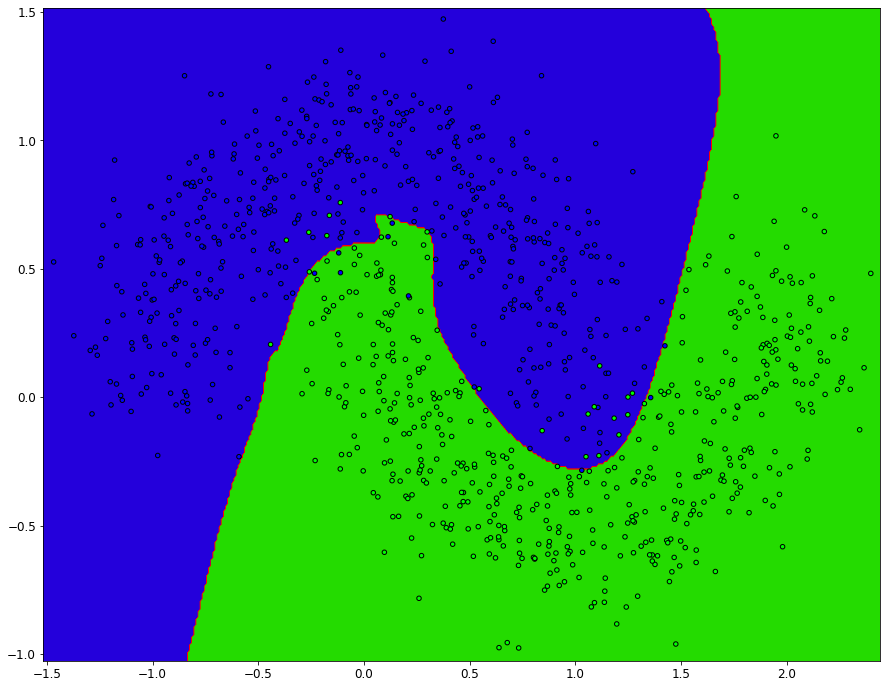

In [ ]:
loss_df = pd.DataFrame(loss_hist)
fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train) # plot decision boundary for this plot

In [ ]:
def fn_make_predicitions(pred_func, X):
    y_pred = pred_func(X)
    return y_pred

In [ ]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_train)
print('Accruacy score on Train Data :', accuracy_score(y_train, y_pred))
print (confusion_matrix(y_train, y_pred))

Accruacy score on Train Data : 0.9716796875
[[513   9]
 [ 20 482]]


In [ ]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_test)

print('Accruacy score on Test Data :', accuracy_score(y_test, y_pred))
print (confusion_matrix(y_test, y_pred))

Accruacy score on Test Data : 0.953125
[[116   2]
 [ 10 128]]


# Story So Far 
<div style="font-family: Arial; font-size:1.2em;color:black;">
    
    
|#|Sheet #|Dataset|Implementation|Training Accuracy|Testing Accuracy|Remarks|
|:-:|:-:|:-:|:--|---|---|:--|
|1|S04a|make_moons|Simple Perceptron|0.84111|0.89000||
|2|S04b|make_moons|Perceptron including Softmax and Gradient Descent|0.86555|0.90000|Training Accuracy catching up|
|3|S06a|make_moons|One hidden layer with ${Tanh}$ activation|0.96875|0.96094| Better, non-linearity helps|
|4|S06b|make_moons|One hidden layer with ${ReLU}$ activation|0.96387|0.96875| Still better, Taking little longer to converge|
|5|S06c|make_moons|One hidden layer with ${Swish}$ activation|0.96680|0.96094| Similar results, Taking even longer to converge|
|6|S06d|make_circles|One hidden layer with ${Tanh}$ activation|0.83643|0.82715| Different dataset|
|7|S06e|make_circles|One hidden layer with ${ReLU}$ activation|0.83130|0.82910| Better than $Tanh$|
|8|S06f|make_circles|One hidden layer with ${Swish}$ activation|0.83471|0.83301| Better than other two|
|9|S07a|make_circles|Multiple Hidden Layers|0.96875|0.96094|Similar results.|
|10|S08a|make_circles|Multiple Hidden Layers L1 regularization|0.97070|0.96094|Similar results.|
|11|S12a|make_circles|Multiple Hidden Layers L2 regularization|0.97070|0.96094|Similar results.|
</div>

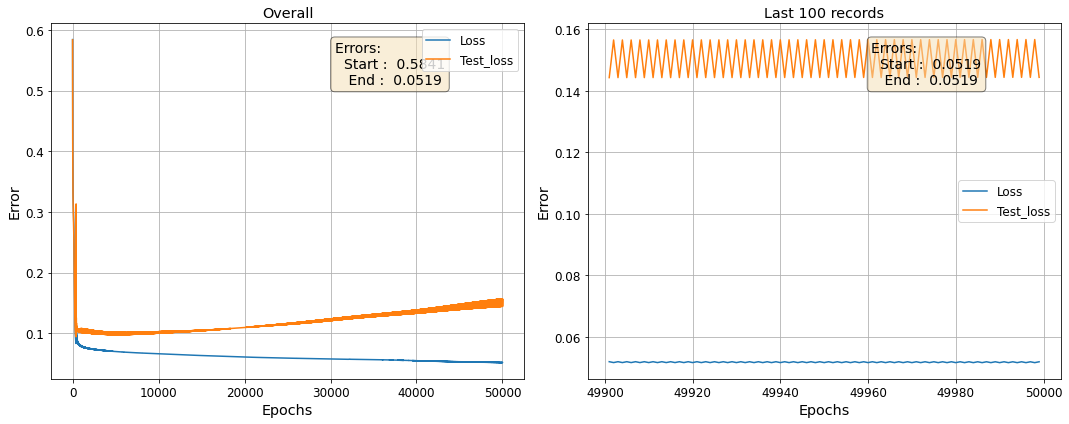

In [ ]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 100

ax = axes[0]

loss_df.plot(x = 'epoch', y = ['Loss', 'Test_loss'], ax = ax)
loss = loss_df['Loss'].values

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid();

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = ['Loss', 'Test_loss'], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()

In [ ]:
# define nodes in each of dims
reg_lambda = LAMBDA

# Build a model with multiple hidden layers
model = build_model(layer_param, X_train, y_train, X_test, y_test,
                           epochs, alpha, reg_lambda, print_loss=True)

Loss after iteration 0: 0.000000, 0.000000
Loss after iteration 1000: 0.087821, 0.142885
Loss after iteration 2000: 0.084487, 0.141476
Loss after iteration 3000: 0.082923, 0.139632
Loss after iteration 4000: 0.081844, 0.138424
Loss after iteration 5000: 0.081008, 0.137660
Loss after iteration 6000: 0.080325, 0.137160
Loss after iteration 7000: 0.079752, 0.136817
Loss after iteration 8000: 0.079267, 0.136572
Loss after iteration 9000: 0.078854, 0.136391
Loss after iteration 10000: 0.078500, 0.136257
Loss after iteration 11000: 0.078195, 0.136159
Loss after iteration 12000: 0.077928, 0.136091
Loss after iteration 13000: 0.077694, 0.136048
Loss after iteration 14000: 0.077487, 0.136027
Loss after iteration 15000: 0.077301, 0.136024
Loss after iteration 16000: 0.077133, 0.136039
Loss after iteration 17000: 0.076978, 0.136069
Loss after iteration 18000: 0.076836, 0.136114
Loss after iteration 19000: 0.076702, 0.136173
Loss after iteration 20000: 0.076576, 0.136247
Loss after iteration 21000

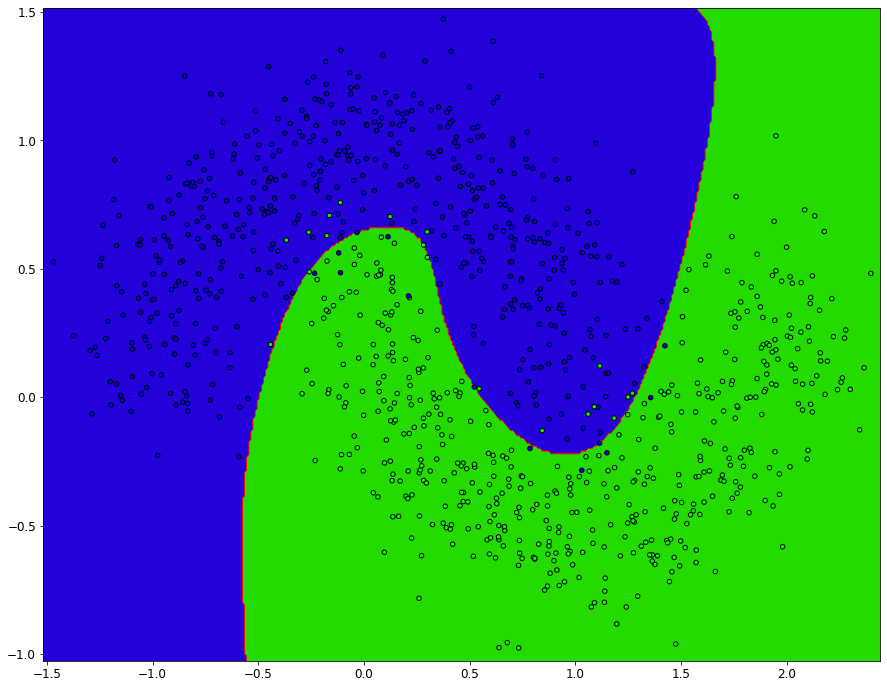

In [ ]:
loss_df = pd.DataFrame(loss_hist)
fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train) # plot decision boundary for this plot

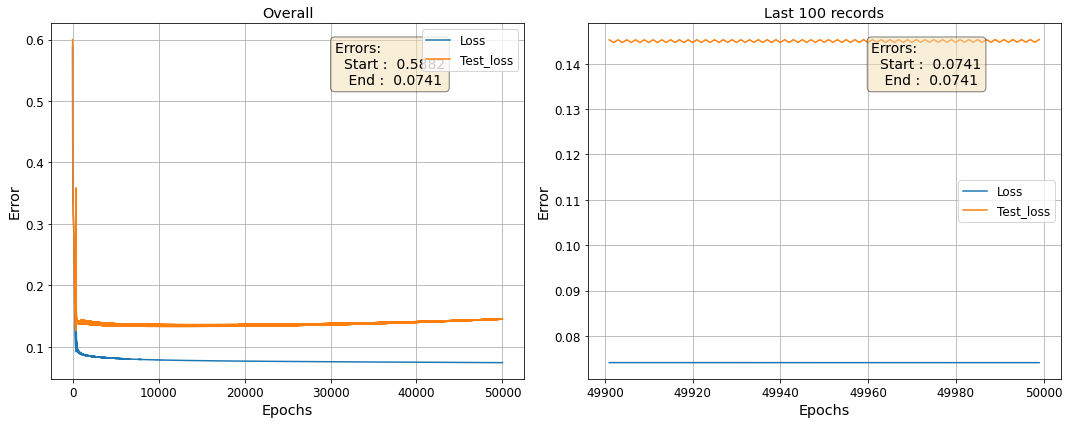

In [ ]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 100

ax = axes[0]

loss_df.plot(x = 'epoch', y = ['Loss', 'Test_loss'], ax = ax)
loss = loss_df['Loss'].values

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid();

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = ['Loss', 'Test_loss'], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()